In [1]:

import os, sys, math, gc
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import seaborn as sns
import lightgbm as lgb
import pickle as pkl
from utils.utils import merge_eval_sold_on_df, sort_df_on_d, WRMSSE, RMSSE, _down_cast, data_preprocessing, diff_lists, log_status
from utils.utils import customIter, cross_validation_on_validation_set, ensemble_submissions, ensemble_submissions_uncertainty
from utils.metrics import WSPL
from utils.configure_logger import configure_logger
from utils import constants

configure_logger()
from logging import getLogger
logger = getLogger(__name__)

import warnings
warnings.simplefilter("ignore")

In [3]:
DATA_BASE_PATH = constants.DATA_BASE_PATH #'../data/m5-forecasting-accuracy/'
DATA_BASE_PATH_UNCERTAINTY = constants.DATA_BASE_PATH_UNCERTAINTY #'../data/m5-forecasting-uncertainty/'
SALES_EVALUATION = constants.SALES_EVALUATION #'sales_train_evaluation.csv'
SALES_VALIDATION = constants.SALES_VALIDATION #'sales_train_validation.csv'
CALENDAR = constants.CALENDAR #'calendar.csv'
SAMPLE_SUBMISSION = constants.SAMPLE_SUBMISSION #'sample_submission.csv'
SELL_PRICES = constants.SELL_PRICES #'sell_prices.csv'

PRECOMPUTED_BASE_PATH = constants.PRECOMPUTED_BASE_PATH #'../data/uncertainty/features/'

DAYS: int = constants.DAYS #28
QUANTILES: int = constants.QUANTILES #[0.005, 0.025, 0.165, 0.25, 0.50, 0.75, 0.835, 0.975, 0.995]

AGG_LEVEL_COLUMNS = constants.AGG_LEVEL_COLUMNS
D_CROSS_VAL_START_LIST = constants.D_CROSS_VAL_START_LIST #[1802, 1830, 1858, 1886, 1914]

# to simple get the precomputed name
precomputed_name = lambda store, eval_val: f'processed_{store}_{eval_val}.pkl'

TEST_PATH = constants.TEST_PATH#'test/'
PREDICTION_BASE_PATH = constants.PREDICTION_BASE_PATH #'../data/uncertainty/temp_submissions/'
SUBMISSION_BASE_PATH = constants.SUBMISSION_BASE_PATH #'../data/uncertainty/final_submissions/'

SUB_D_START_VAL: int = constants.SUB_D_START_VAL #1914
SUB_D_START_EVAL: int = constants.SUB_D_START_EVAL #1914 + 28

# the columns are always included after feature processing
# because they are required in the training and submission format
DROP_FEATURE_COLUMNS: list = constants.DROP_FEATURE_COLUMNS #['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'd', 'sold']

### Define GridSearch functions

In [4]:
@log_status
def grid_search(params: dict, param_grid: dict, features, targets, n_folds: int = 1):
    """ 
    Given a grid with parameters, train lgb model for all possible combinations.
    Returns the parameter set with the best score and the dictionary with all results.
    """
    import itertools
    
    # to be sure
    features = features.reset_index(drop=True)
    targets = targets.reset_index(drop=True)

    param_combinations = list(itertools.product(*param_grid.values()))
    results = {}
    for i, param_combination in enumerate(param_combinations,1):
        
        # create dictionary with all parameters
        param_combination = {k:v for k,v in zip(param_grid.keys(), param_combination)}
        param_combination.update(params)
        
        # init dict
        results[f"combination_{i}"] = {
            'params': param_combination,
            'res': []
        }
        
        # perform n_folds
        # from sklearn.model_selection import KFold
        # kfold = KFold(n_splits=n_folds)
        # for j, (train_idx, validation_idx) in enumerate(kfold.split(features)):
        
        for j in range(n_folds):
            
            # kfold
            features_train, features_validation, targets_train, targets_validation =\
                train_test_split(features, targets, train_size = .8, shuffle=True, random_state=42)
        
            # # split data for fold
            # features_train, features_validation = features.loc[train_idx], features.loc[validation_idx]
            # targets_train, targets_validation = targets.loc[train_idx], targets.loc[validation_idx]

            # normalize
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            
            targets_train = scaler\
                .fit_transform(targets_train.values.reshape(-1,1))\
                .reshape(-1)
            targets_validation = scaler\
                .transform(targets_validation.values.reshape(-1,1))\
                .reshape(-1)

            # train lgb model        
            temp_dict = {} # this dict object will be used to add all (intermediate) evaluation scores during the training process
            mod: lgb.Booster = lgb.train(param_combination, 
                train_set = lgb.Dataset(features_train, targets_train),
                valid_sets = lgb.Dataset(features_validation, targets_validation),
                evals_result = temp_dict
            )
            
            # store results
            results[f"combination_{i}"]['res']\
                .append(temp_dict["valid_0"]["quantile"][-1],
            )

        # compute average results
        results[f"combination_{i}"]['validation_score'] = \
            np.mean(results[f"combination_{i}"]['res'])
        
    # sort the results based on evaluation score
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1]["validation_score"]))
    return list(sorted_results.values())[-1], results

In [14]:
class LoadData:
    def __init__(self):
        self.level = None
        
    def prep_data(self,level):
        """ read the precomputed features and targets for specified aggregation level,  """
        # define params
        agg_level = level
        sub_d_start: int = int(1886)
        exclude_columns = []
        test = False
        type_of = 'val'

        # read file
        agg_columns = AGG_LEVEL_COLUMNS[agg_level]
        if len(agg_columns) == 0:
            agg_str: str = 'Total_X'
        elif len(agg_columns) == 1:
            agg_str: str = f'{agg_columns[0]}_X'
        else:
            agg_str: str = '_'.join(agg_columns)

        if self.level == level:
            pass
        else:
            logger.info('(re)loading features')
            features = pd.read_parquet(f'../data/uncertainty/fold_{sub_d_start}/features/' + (TEST_PATH if test else '') + f'features_{type_of}_{agg_str}.parquet')
            features = _down_cast(features)

        group_columns = agg_columns
        exclude_prefix_list = exclude_columns # unconditional, auto, momentum, seasonal

        features_gr = features.copy()
        features_gr = features_gr[[c for c in features_gr if c.split('_')[0] not in exclude_prefix_list]]

        # preparations
        train_idx = features_gr['sold'].notna() & features_gr['d'].isin([f'd_{sub_d_start - 1 - i}' for i in range(1460)])
        df_train = features_gr[train_idx]
        features_train: pd.DataFrame = df_train.drop(DROP_FEATURE_COLUMNS, axis = 1, errors = 'ignore')
        targets_train: pd.Series = df_train['sold']
        return features_train, targets_train

In [19]:
level = 'Level5'
q = .025
n_est = 50 # 200
lr = .1 #.2

def prefixes_in_column(column, prefixes):
    s = 0
    for prefix in prefixes:
        s += prefix_in_column(column, prefix)
    return True if s>0 else False

def prefix_in_column(column, prefix):
    return 1 if prefix in column else 0

dataLoader = LoadData()
features, targets = dataLoader.prep_data(level)
features

2023-11-10 13:29:01 - __main__ - INFO - (re)loading features


,auto_sold_7,auto_sold_14,auto_sold_2,auto_sold_1,auto_sold_21,auto_sold_ma_180,auto_sold_ma_60,auto_sold_ma_28,auto_sold_ma_std_7,auto_sold_ma_std_60,...,seasonal_3,seasonal_9,seasonal_2,seasonal_5,seasonal_Monday,seasonal_Wednesday,seasonal_Tuesday,seasonal_12,seasonal_Saturday,seasonal_d_int
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1002.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1003.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1004.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13337,1247.0,1280.0,1963.0,1192.0,1260.0,1567.0,1535.0,1496.0,342.50,280.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,995.0
13338,1257.0,1304.0,1192.0,1117.0,1309.0,1566.0,1528.0,1484.0,346.75,282.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,996.0
13339,1272.0,1431.0,1117.0,1217.0,1412.0,1565.0,1521.0,1456.0,352.50,285.00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,997.0
13340,1511.0,1171.0,1217.0,1213.0,1832.0,1566.0,1509.0,1435.0,358.00,280.50,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,998.0


In [20]:
prefixes = ['autoquantiles_']
features[[c for c in features.columns if prefixes_in_column(c, prefixes)]]

,autoquantiles_sold_ma_180_0.25,autoquantiles_sold_ma_180_0.995,autoquantiles_sold_ma_60_0.995,autoquantiles_sold_ma_180_0.005,autoquantiles_sold_ma_30_0.025,autoquantiles_sold_ma_30_0.75,autoquantiles_sold_ma_180_0.75,autoquantiles_sold_ma_30_0.995,autoquantiles_sold_ma_180_0.975,autoquantiles_sold_ma_60_0.005,...,autoquantiles_sold_ma_60_0.5,autoquantiles_sold_ma_60_0.025,autoquantiles_sold_ma_60_0.165,autoquantiles_sold_ma_30_0.5,autoquantiles_sold_ma_60_0.25,autoquantiles_sold_ma_30_0.25,autoquantiles_sold_ma_60_0.975,autoquantiles_sold_ma_30_0.005,autoquantiles_sold_ma_30_0.835,autoquantiles_sold_ma_60_0.835
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13337,1357.0,2194.0,2084.0,1075.0,1156.0,1827.0,1760.0,2013.0,2096.0,1133.0,...,1458.0,1181.0,1262.0,1319.0,1296.0,1263.0,2042.0,1125.0,1871.0,1872.0
13338,1357.0,2194.0,2084.0,1075.0,1156.0,1827.0,1760.0,2013.0,2096.0,1133.0,...,1442.0,1181.0,1259.0,1319.0,1279.0,1263.0,2042.0,1125.0,1871.0,1872.0
13339,1355.0,2194.0,2084.0,1075.0,1156.0,1827.0,1760.0,2013.0,2096.0,1133.0,...,1430.0,1181.0,1256.0,1307.0,1276.0,1258.0,2042.0,1125.0,1871.0,1872.0
13340,1355.0,2194.0,2084.0,1078.0,1156.0,1827.0,1760.0,2013.0,2096.0,1133.0,...,1420.0,1181.0,1252.0,1304.0,1270.0,1250.0,2042.0,1125.0,1871.0,1842.0


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[1]	valid_0's quantile: 130.123
[2]	valid_0's quantile: 130.123
[3]	valid_0's quantile: 130.123
[4]	valid_0's quantile: 130.123
[5]	valid_0's quantile: 130.123
[6]	valid_0's quantile: 130.123
[7]	valid_0's quantile: 130.123
[8]	valid_0's quantile: 130.122
[9]	valid_0's quantile: 130.122
[10]	valid_0's quantile: 130.122
[11]	valid_0's quantile: 130.122
[12]	valid_0's quantile: 130.122
[13]	valid_0's quantile: 130.122
[14]	valid_0's quantile: 130.121
[15]	valid_0's quantile: 130.121
[16]	valid_0's quantile: 130.121
[17]	valid_0's quantile: 130.121
[18]	valid_0's quantile: 130.121
[19]	valid_0's quantile: 130.121
[20]	valid_0's quantile: 130.121
[21]	valid_0's quantile: 130.12
[22]	valid_0's quantile: 130.119
[23]	valid_0's quantile: 130.119
[24]	valid_0's quantile: 130.119
[25]	valid_0's quantile: 130.119
[26]	valid_0's quantile: 130.119
[27]	valid_0's quantile: 130.118
[2

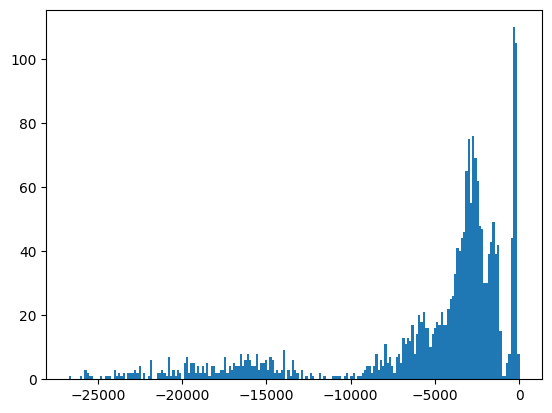

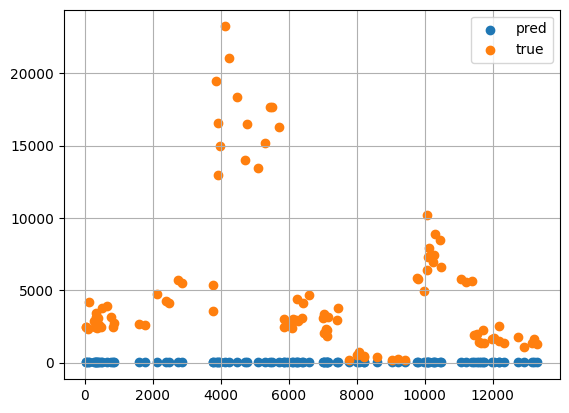

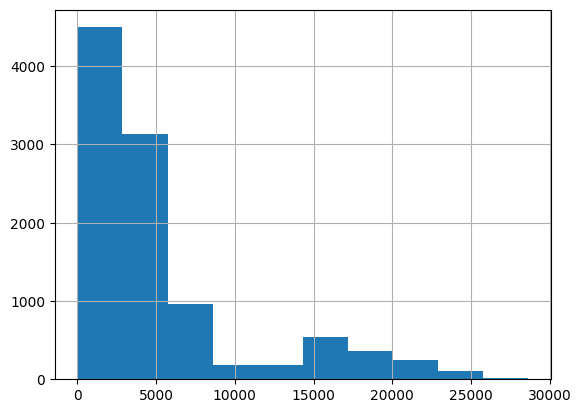

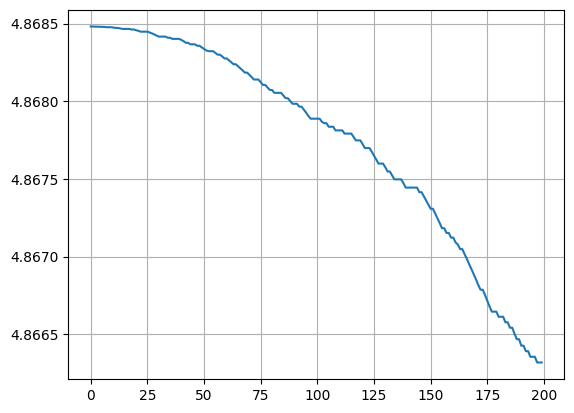

In [26]:

# kfold
prefixes = ['autoquantiles_']
features_train, features_validation, targets_train, targets_validation =\
    train_test_split(features[[c for c in features.columns if prefixes_in_column(c, prefixes)]], targets, train_size = .8, shuffle=True, random_state=42)

# undersample training features
under_sample_pct = .01
features_train, _, targets_train, _ = train_test_split(features_train, targets_train, train_size=under_sample_pct, shuffle=True, random_state=42)

# define params
n_est = 200
lr = .001
params = {
    'objective': 'quantile',
    'metric': 'quantile', # Use Root Mean Squared Error (RMSE) as the evaluation metric
    'boosting_type': 'gbdt',
    'random_state': 43,
    'verbose': -1,
    'n_jobs': 4,
    'subsample': .5,#.5
    'subsample_freq': 1,
    "num_leaves": 2**8-1,#2**8-1,
    # 'min_data_in_leaf': 15,#2**8-1,
    'feature_fraction': 1, #.5
    'bagging_fraction': .8,
    "learning_rate": lr,
    "n_estimators": n_est,#100
    # "max_bin": 100,
    'boost_from_average': False,
    # "tweedie_variance_power": 1.1, # Set the Tweedie variance power (1 <= p <= 2)
    
    'reg_sqrt': True,
    'alpha': q,
}

# # normalize
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# targets_train = scaler\
#     .fit_transform(targets_train.values.reshape(-1,1))\
#     .reshape(-1)
# targets_validation = scaler\
#     .transform(targets_validation.values.reshape(-1,1))\
#     .reshape(-1)

# train lgb model        
temp_dict = {}
mod: lgb.Booster = lgb.train(params, 
    train_set = lgb.Dataset(features_train, targets_train),
    valid_sets = lgb.Dataset(features_validation, targets_validation),
    evals_result = temp_dict
)

# plot distribution of residuals, should have roughly q*n values on the left, and (1-q)*n values on the right
plt.hist(mod.predict(features_validation) - targets_validation, bins=200)
plt.show()

# plot prediction vs. true outcome (with quantile regression, this should correspond to confidence bounds)
n = 100
idx = targets_validation[:n].index
plt.scatter(idx, mod.predict(features_validation)[:n], label = 'pred')
plt.scatter(idx, targets_validation[:n], label = 'true')
plt.legend()
plt.grid()
plt.show()

# plot histogram of targets 
plt.hist(targets)
plt.grid()
plt.show()

# plot log(loss) of training iterations to get insights in convergence
plt.plot(np.log(temp_dict["valid_0"]["quantile"]))
plt.grid()
plt.show()

In [27]:
features.columns

Index(['auto_sold_7', 'auto_sold_14', 'auto_sold_2', 'auto_sold_1',
       'auto_sold_21', 'auto_sold_ma_180', 'auto_sold_ma_60',
       'auto_sold_ma_28', 'auto_sold_ma_std_7', 'auto_sold_ma_std_60',
       'auto_sold_ma_7', 'auto_sold_ma_std_180', 'auto_sold_ma_std_28',
       'autoquantiles_sold_ma_180_0.25', 'autoquantiles_sold_ma_180_0.995',
       'autoquantiles_sold_ma_60_0.995', 'autoquantiles_sold_ma_180_0.005',
       'autoquantiles_sold_ma_30_0.025', 'autoquantiles_sold_ma_30_0.75',
       'autoquantiles_sold_ma_180_0.75', 'autoquantiles_sold_ma_30_0.995',
       'autoquantiles_sold_ma_180_0.975', 'autoquantiles_sold_ma_60_0.005',
       'autoquantiles_sold_ma_30_0.975', 'autoquantiles_sold_ma_60_0.75',
       'autoquantiles_sold_ma_180_0.165', 'autoquantiles_sold_ma_30_0.165',
       'autoquantiles_sold_ma_180_0.835', 'autoquantiles_sold_ma_180_0.025',
       'autoquantiles_sold_ma_180_0.5', 'autoquantiles_sold_ma_60_0.5',
       'autoquantiles_sold_ma_60_0.025', 'autoquant

### Quick Run for Testing (Cross Validation)

In [28]:
# total ~280 seconds
params = {
    'objective': 'quantile',
    'metric': 'quantile', # Use Root Mean Squared Error (RMSE) as the evaluation metric
    'boosting_type': 'gbdt',
    'random_state': 43,
    'verbose': 1,
    'n_jobs': 4,
    'eval_at': 100,
    # 'verbose_eval': 0
    'subsample': 0.5,
    'subsample_freq': 1,
    'feature_fraction': 0.5,
    'boost_from_average': False,
    'alpha': .975
}

param_grid = {
    "num_leaves": [255], #[int(2**i) for i in [5, 6, 8]],
    'min_data_in_leaf': [255], #[int(2**i -1) for i in [5, 6, 8]]
    "learning_rate": [0.01],#[0.04, 0.02, 0.01, 0.005],
    "n_estimators": [5000], # [5000, 500, 100]
    # "tweedie_variance_power": [1.1], # Set the Tweedie variance power (1 <= p <= 2)
    # 'max_bin': [100]
}

In [18]:
# features_train, targets_train = prep_data('Level5')
# grid_search(params, param_grid, features_train, targets_train, 1)

# Train + Predict submission

In [32]:
def train_level_all_quantiles(agg_level: str, type_of: str, sub_d_start: int, exclude_columns: list = [], test: bool = False, do_grid_search: bool = False, store_submissions_path: str = 'temp_submissions/'):
    """ 
    Train, for a specific aggregation level, models for all quantiles.
    For aggregation levels 10, 11 and 12, undersampling is used to drastically reduce training time.
    """

    # type_of = 'val'
    # test = False
    # agg_level = 'Level1'
    
    agg_columns = AGG_LEVEL_COLUMNS[agg_level]
    if len(agg_columns) == 0:
        agg_str: str = 'Total_X'
    elif len(agg_columns) == 1:
        agg_str: str = f'{agg_columns[0]}_X'
    else:
        agg_str: str = '_'.join(agg_columns)

    try:
        features = pd.DataFrame(features)
    except Exception:
        logger.info('(re)loading features')
        features = pd.read_parquet(f'../data/uncertainty/fold_{sub_d_start}/features/' + (TEST_PATH if test else '') + f'features_{type_of}_{agg_str}.parquet')
        features = _down_cast(features)
        
    features_gr = features.copy()

    group_columns = agg_columns
    res: list = []

    exclude_prefix_list = exclude_columns # unconditional, auto, momentum, seasonal
    columns = [c for c in features_gr if c.split('_')[0] not in exclude_prefix_list]
    features_gr = features_gr[columns]
    
    # preparations
    # sub_d_start = SUB_D_START_VAL if type_of == 'val' else SUB_D_START_EVAL
    train_idx = features_gr['sold'].notna() & features_gr['d'].isin([f'd_{sub_d_start - 1 - i}' for i in range(1460)])
    pred_idx = features_gr['d'].isin([f'd_{sub_d_start + i}' for i in range(28)])
    df_train = features_gr[train_idx]
    df_pred = features_gr[pred_idx]
    features_train: pd.DataFrame = df_train.drop(DROP_FEATURE_COLUMNS, axis = 1, errors = 'ignore')
    targets_train: pd.Series = df_train['sold']
    features_predict: pd.DataFrame = df_pred.drop(DROP_FEATURE_COLUMNS, axis = 1, errors = 'ignore')
    
    undersampling_dict = {
        'Level3': .5,
        'Level4': .5,
        'Level5': .5,
        'Level6': .3,
        'Level7': .3,
        'Level8': .3,
        'Level9': .2,
        'Level10': .2,
        'Level11': .05,
        'Level12': .01
    }
    if agg_level in undersampling_dict:
        undersampling_pct = undersampling_dict[agg_level]
        features_train, _, targets_train, _ = train_test_split(features_train, targets_train, train_size = undersampling_pct, shuffle=True, random_state=43)

    # normalise targets
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    targets_train = scaler.fit_transform(targets_train.values.reshape(-1,1))
        
    # train model for all quantiles
    for quantile in QUANTILES:
        
        # perform grid search for best parameters
        if do_grid_search == True:
            # split data to training and testing
            logger.info('divide for cross validation')
            x_train, x_test, y_train, y_test = train_test_split(features_train, targets_train, train_size=.8, shuffle=False, random_state=42)
            train_data = lgb.Dataset(x_train, y_train)
            validation_data = lgb.Dataset(x_test, y_test)
            logger.info('perform gridsearch')
            best_combination, results = grid_search(params, param_grid, train_data = train_data, validation_data = validation_data)
            del train_data; del validation_data
            params_grid_train = best_combination["params"]
        else:
            params_grid_train = {
                'objective': 'quantile',
                'metric': 'quantile', # Use Root Mean Squared Error (RMSE) as the evaluation metric
                'boosting_type': 'gbdt',
                'random_state': 43,
                'verbose': -1,
                'n_jobs': 4,
                'subsample': .5,#.5
                'subsample_freq': 1,
                "num_leaves": 2**8-1,#2**8-1,
                # 'min_data_in_leaf': 15,#2**8-1,
                'feature_fraction': 0.5, #.5
                'bagging_fraction': .8,
                "learning_rate": 0.2,
                "n_estimators": 500,#100
                # "max_bin": 100,
                'boost_from_average': False,
                # "tweedie_variance_power": 1.1, # Set the Tweedie variance power (1 <= p <= 2)
                
                'reg_sqrt': True,
                'alpha': quantile,
            }

        # train_best_model
        mod = lgb.train(params_grid_train,
            train_set = lgb.Dataset(features_train, targets_train)
        )
        predictions = mod.predict(features_predict)
        predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,)
        
        # store predictions
        df_p = pd.DataFrame(
            {
                'pred': predictions,
                'd': df_pred['d'],
            }
        )
        df_p['quantile'] = quantile
        df_p['Level'] = agg_level
        df_p['type_of'] = 'validation' if type_of == 'val' else 'evaluation'
        if len(agg_columns) == 0:
            df_p['agg_column1'] = 'Total'
            df_p['agg_column2'] = 'X'
        elif len(agg_columns) == 1:
            df_p['agg_column1'] = df_pred[agg_columns[0]].values
            df_p['agg_column2'] = 'X'
        else:
            df_p['agg_column1'] = df_pred[agg_columns[0]].values
            df_p['agg_column2'] = df_pred[agg_columns[1]].values
            
        df_p = df_p[['Level', 'agg_column1', 'agg_column2', 'd', 'quantile', 'pred', 'type_of']]
        
        res.append(_down_cast(df_p))
        
    # remove to reduce memory usage asap
    del features
        
    # storing predictions in specified file + folder
    df_sub_val = pd.concat(res)
    group_names = '_'.join(group_columns)
    if group_names == '':
        group_names = 'Total_X'
    exclude_names = 'None' if len(exclude_prefix_list) == 0 else '_'.join(exclude_prefix_list)
    df_sub_val.to_csv(f'../data/uncertainty/fold_{str(sub_d_start)}/' + store_submissions_path + f'lgb_multivariate_{type_of}_non_transposed_{group_names}_exclude_{exclude_names}.csv', index = False)
    logger.info('saved under: ' + f'../data/uncertainty/fold_{str(sub_d_start)}/' + store_submissions_path + f'lgb_multivariate_{type_of}_non_transposed_{group_names}_exclude_{exclude_names}.csv')

In [33]:
# all groups: seasonal, auto, autoquantiles, momentum

EXCLUDE_COLUMNS_LIST = (
    # [],
    # ['seasonal'],
    # ['auto'],
    # ['autoquantiles'],
    # ['momentum'],
    ['seasonal', 'auto', 'momentum'] # only autocorrelated quantiles
)

EXCLUDE_COLUMNS_LIST = (
    # [],
    # ['seasonal'],
    # ['momentum'],
    # ['autoquantiles'],
    # ['auto'],
    ['seasonal', 'auto', 'momentum'],
    # ['auto', 'momentum']
)

for exclude_columns in EXCLUDE_COLUMNS_LIST: # for each specified feature combination
    for sub_d_start in D_CROSS_VAL_START_LIST: # for each fold
        for agg_level in AGG_LEVEL_COLUMNS: # for each aggregation level
            logger.info(f'starting with agg_level: {agg_level}')
            train_level_all_quantiles(
                agg_level, 
                sub_d_start=sub_d_start,
                type_of='val', 
                exclude_columns=exclude_columns,
                do_grid_search=False,
                store_submissions_path='temp_submissions_research/'
            )

2023-11-08 18:15:02 - __main__ - INFO - starting with agg_level: Level1
2023-11-08 18:15:02 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8


2023-11-08 18:15:10 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions_research/lgb_multivariate_val_non_transposed_Total_X_exclude_seasonal_auto_momentum.csv
2023-11-08 18:15:10 - __main__ - INFO - starting with agg_level: Level2
2023-11-08 18:15:10 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:15:35 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions_research/lgb_multivariate_val_non_transposed_state_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:15:35 - __main__ - INFO - starting with agg_level: Level3
2023-11-08 18:15:35 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:16:19 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions_research/lgb_multivariate_val_non_transposed_store_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:16:19 - __main__ - INFO - starting with agg_level: Level4
2023-11-08 18:16:19 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:16:36 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions_research/lgb_multivariate_val_non_transposed_cat_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:16:36 - __main__ - INFO - starting with agg_level: Level5
2023-11-08 18:16:36 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:17:02 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions_research/lgb_multivariate_val_non_transposed_dept_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:17:02 - __main__ - INFO - starting with agg_level: Level6
2023-11-08 18:17:02 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:17:23 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions_research/lgb_multivariate_val_non_transposed_state_id_cat_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:17:23 - __main__ - INFO - starting with agg_level: Level7
2023-11-08 18:17:23 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:18:12 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions_research/lgb_multivariate_val_non_transposed_state_id_dept_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:18:12 - __main__ - INFO - starting with agg_level: Level8
2023-11-08 18:18:12 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:19:00 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions_research/lgb_multivariate_val_non_transposed_store_id_cat_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:19:00 - __main__ - INFO - starting with agg_level: Level9
2023-11-08 18:19:00 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:20:02 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions_research/lgb_multivariate_val_non_transposed_store_id_dept_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:20:02 - __main__ - INFO - starting with agg_level: Level10
2023-11-08 18:20:02 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:24:14 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions_research/lgb_multivariate_val_non_transposed_item_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:24:14 - __main__ - INFO - starting with agg_level: Level11
2023-11-08 18:24:14 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:28:35 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions_research/lgb_multivariate_val_non_transposed_state_id_item_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:28:35 - __main__ - INFO - starting with agg_level: Level12
2023-11-08 18:28:35 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:34:08 - __main__ - INFO - saved under: ../data/uncertainty/fold_1802/temp_submissions_research/lgb_multivariate_val_non_transposed_item_id_store_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:34:08 - __main__ - INFO - starting with agg_level: Level1
2023-11-08 18:34:08 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:34:15 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions_research/lgb_multivariate_val_non_transposed_Total_X_exclude_seasonal_auto_momentum.csv
2023-11-08 18:34:15 - __main__ - INFO - starting with agg_level: Level2
2023-11-08 18:34:15 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:34:39 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions_research/lgb_multivariate_val_non_transposed_state_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:34:39 - __main__ - INFO - starting with agg_level: Level3
2023-11-08 18:34:39 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:35:13 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions_research/lgb_multivariate_val_non_transposed_store_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:35:13 - __main__ - INFO - starting with agg_level: Level4
2023-11-08 18:35:13 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:35:24 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions_research/lgb_multivariate_val_non_transposed_cat_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:35:24 - __main__ - INFO - starting with agg_level: Level5
2023-11-08 18:35:24 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:35:55 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions_research/lgb_multivariate_val_non_transposed_dept_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:35:55 - __main__ - INFO - starting with agg_level: Level6
2023-11-08 18:35:55 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:36:15 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions_research/lgb_multivariate_val_non_transposed_state_id_cat_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:36:15 - __main__ - INFO - starting with agg_level: Level7
2023-11-08 18:36:15 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:37:05 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions_research/lgb_multivariate_val_non_transposed_state_id_dept_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:37:05 - __main__ - INFO - starting with agg_level: Level8
2023-11-08 18:37:05 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:37:57 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions_research/lgb_multivariate_val_non_transposed_store_id_cat_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:37:57 - __main__ - INFO - starting with agg_level: Level9
2023-11-08 18:37:57 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 

2023-11-08 18:39:02 - __main__ - INFO - saved under: ../data/uncertainty/fold_1830/temp_submissions_research/lgb_multivariate_val_non_transposed_store_id_dept_id_exclude_seasonal_auto_momentum.csv
2023-11-08 18:39:02 - __main__ - INFO - starting with agg_level: Level10
2023-11-08 18:39:02 - __main__ - INFO - (re)loading features


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.5 will be ignored. Current value: bagging_fraction=0.8


KeyboardInterrupt: 

### Load val + eval prediction files and merge to one submission file

In [15]:
# exclude_columns = '_'.join([])
# if exclude_columns == '':
#     exclude_columns = 'None'

# dfs: list = []
# for level in AGG_LEVEL_COLUMNS:
#     agg_columns = AGG_LEVEL_COLUMNS[level]
#     group_names = '_'.join(agg_columns)
#     if group_names == '':
#         group_names = 'Total_X'
#     i = str(1802)
#     dfs.append(
#         f'../data/uncertainty/fold_{i}/temp_submissions/' + f'lgb_multivariate_val_non_transposed_{group_names}_exclude_{exclude_columns}.csv',
#     )

# df_sub_val = ensemble_submissions_uncertainty(dfs)
# transpose = True
# if transpose == True:
#     sub_validation = df_sub_val.pivot(index='id', columns='d', values='pred').reset_index(drop=False)
#     sub_validation.columns = ["id"] + [f"F{i}" for i in range(1,DAYS+1)]

In [20]:
def read_concat_predictions(fold_name: int, exclude_columns: list = []):
    """ 
    For specified fold, read the predictions for all aggregation levels and stack them together in one dataframe.
    """
    # D_CV_START_LIST
    # if fold_name not in D_CV_START_LIST:
        # raise ValueError('fold_name must be a value in D_CV_START_LIST')
        
    exclude_columns = '_'.join(exclude_columns)
    if exclude_columns == '':
        exclude_columns = 'None'

    logger.info('loading files under path:' + f'../data/uncertainty/fold_{fold_name}/temp_submissions/')

    dfs: list = []
    for level in AGG_LEVEL_COLUMNS:
        agg_columns = AGG_LEVEL_COLUMNS[level]
        group_names = '_'.join(agg_columns)
        if group_names == '':
            group_names = 'Total_X'

        dfs.append(
            f'../data/uncertainty/fold_{fold_name}/temp_submissions/' + f'lgb_multivariate_val_non_transposed_{group_names}_exclude_{exclude_columns}.csv',
        )

    return ensemble_submissions_uncertainty(dfs)

In [5]:
# exclude_columns = '_'.join([])
# if exclude_columns == '':
#     exclude_columns = 'None'

# dfs: list = []
# for level in AGG_LEVEL_COLUMNS:
#     agg_columns = AGG_LEVEL_COLUMNS[level]
#     group_names = '_'.join(agg_columns)
#     if group_names == '':
#         group_names = 'Total_X'
        
#     dfs.append(
#         PREDICTION_BASE_PATH + f'lgb_multivariate_eval_non_transposed_{group_names}_exclude_{exclude_columns}.csv',
#     )

# df_sub_eval = ensemble_submissions_uncertainty(dfs)
# transpose = True
# if transpose == True:
#     sub_evaluation = df_sub_eval.pivot(index='id', columns='d', values='pred').reset_index(drop=False)
#     sub_evaluation.columns = ["id"] + [f"F{i}" for i in range(1,DAYS+1)]

In [6]:
# # sub_evaluation = pd.read_csv('../submissions/submission_baseline_evaluation.csv').drop(['Unnamed: 0'], axis=1)
# pd.concat([sub_validation, sub_evaluation]).to_csv(SUBMISSION_BASE_PATH + f'submission_lgb_ensemble{exclude_columns}.csv', index=False)
# del sub_validation; del sub_evaluation

### For Validation Prediction, we can compute WRMSSE locally

In [21]:
# these variables are used later on
d = pd.read_parquet('../data/uncertainty/cv_template/temp.parquet')
d_int = d['d'].str.split('_').apply(lambda x: int(x[1]))

In [8]:
def perform_cv(df: pd.DataFrame, df_sub: pd.DataFrame):
    
    # to be able to merge
    df_sub['id_merge'] = df_sub['id'].str.split('.')\
        .apply(lambda x: x[0])
    df_sub['quantile'] = df_sub['id'].str.split('.')\
        .apply(lambda x: float('.'.join([x[-2], x[-1].split('_')[0]])))

    # merge predictions in cv template
    p = pd.merge(
        df,
        df_sub,
        how='left',
        on=['id_merge', 'd']
    )
    # del df; del df_sub_val
    p['id_merge'] = p['id_merge'].astype(str)

    for c in ['sold', 'revenue']:
        p[c] = p[c].astype(np.float32)
    # d = d[d_int < (D_CV_START + 28)]

    return WSPL(p, [f'd_{i}' for i in range(D_CV_START, D_CV_START + 500)])

In [9]:
EXCLUDE_COLUMNS_LIST = (
    [],
    ['seasonal'],
    ['auto'],
    ['autoquantiles'],
    ['momentum'],
)

EXCLUDE_COLUMNS_LIST = (
    # ['seasonal'],
    # ['momentum'],
    # ['autoquantiles'],
    ['seasonal', 'auto', 'momentum'],
    ['auto', 'momentum'],
)

for EXCLUDE_COLUMNS in EXCLUDE_COLUMNS_LIST:
    logger.info('--------------- ' + str(EXCLUDE_COLUMNS) + ' ---------------')
    res = []
    for D_CV_START in D_CROSS_VAL_START_LIST:
        mean_wspl = perform_cv(_down_cast(d)[d_int < (D_CV_START + 28)], read_concat_predictions(D_CV_START, EXCLUDE_COLUMNS))
        res.append(mean_wspl)
        logger.info(str(D_CV_START) + ' - wspl: ' + str(mean_wspl))
        
    logger.info(str(D_CV_START) + ' - mean wspl: ' + str(np.mean(res)) + ' +/- ' + str(np.std(res)))
    logger.info(str(D_CV_START) + ' - raw results: ' + str(res))

2023-08-23 11:01:20 - __main__ - INFO - --------------- ['seasonal', 'auto', 'momentum'] ---------------
2023-08-23 11:01:32 - __main__ - INFO - loading files under path:../data/uncertainty/fold_1802/temp_submissions/
2023-08-23 11:02:23 - utils.metrics - INFO - reading weights file
2023-08-23 11:02:23 - utils.metrics - INFO - sorting df on d ...
2023-08-23 11:02:55 - utils.metrics - INFO - entering loop ...
2023-08-23 11:03:02 - utils.metrics - INFO - Level1 - 0.5094243163667926
2023-08-23 11:03:13 - utils.metrics - INFO - Level10 - 0.2974691040013057
2023-08-23 11:03:47 - utils.metrics - INFO - Level11 - 0.2925593341513246
2023-08-23 11:05:44 - utils.metrics - INFO - Level12 - 0.28617993644852113
2023-08-23 11:05:44 - utils.metrics - INFO - Level2 - 0.41335436599424047
2023-08-23 11:05:45 - utils.metrics - INFO - Level3 - 0.39246218255236165
2023-08-23 11:05:45 - utils.metrics - INFO - Level4 - 0.4088971129355237
2023-08-23 11:05:45 - utils.metrics - INFO - Level5 - 0.419405669054789

### Code Beneath can be used to create submission template
The submission template can be used to quickly insert your predictions.
It also contains all other (historical) sales to be able to compute the WRMSSE

In [4]:
sales_validation = pd.read_csv(DATA_BASE_PATH + SALES_VALIDATION)
sales_evaluation = pd.read_csv(DATA_BASE_PATH + SALES_EVALUATION)
calendar = pd.read_csv(DATA_BASE_PATH + CALENDAR)
sell_prices = pd.read_csv(DATA_BASE_PATH + SELL_PRICES)

df_val, submission_idx_val = data_preprocessing(sales_validation, calendar, sell_prices)
del sales_validation
df_eval, submission_idx_eval = data_preprocessing(sales_evaluation, calendar, sell_prices)
del sales_evaluation

df_val_after_release = df_val[(df_val.wm_yr_wk > df_val.release)]# & (df_val["sold"].notna())]
del df_val
df_eval_after_release = df_eval[(df_eval.wm_yr_wk > df_eval.release)]# & (df_eval["sold"].notna())]
del df_eval

In [7]:
dfs = []
df_eval_after_release['revenue'] = df_eval_after_release['sold'] * df_eval_after_release['sell_price']
for level in list(AGG_LEVEL_COLUMNS.keys()):
    c = AGG_LEVEL_COLUMNS[level]
    logger.info(level)
    agg_dict = {
        'sold': 'sum',
        'revenue': 'sum'
    }
    d1 = df_eval_after_release.groupby(c + ['d']).agg(agg_dict).reset_index(drop=False)
    d = pd.DataFrame({
        'd': d1['d'],
        'sold': d1['sold'],
        'revenue': d1['revenue']
    })
    if len(c) == 0:
        d['agg_column1'] = 'Total'
        d['agg_column2'] = 'X'
    elif len(c) == 1:
        d['agg_column1'] = d1[c[0]]
        d['agg_column2'] = 'X'
    else:
        d['agg_column1'] = d1[c[0]]
        d['agg_column2'] = d1[c[1]]
    d['id_merge'] = d['agg_column1'] + '_' + d['agg_column2']
    d['Level'] = level
    dfs.append(d[['Level', 'agg_column1', 'agg_column2', 'd', 'sold', 'revenue', 'id_merge']])
d = pd.concat(dfs)
d.head(50)
d.to_parquet('temp.parquet', index=False)

2023-08-17 17:27:39 - __main__ - INFO - Level1
2023-08-17 17:27:40 - __main__ - INFO - Level2
2023-08-17 17:27:44 - __main__ - INFO - Level3
2023-08-17 17:27:48 - __main__ - INFO - Level4
2023-08-17 17:27:51 - __main__ - INFO - Level5
2023-08-17 17:27:55 - __main__ - INFO - Level6
2023-08-17 17:28:00 - __main__ - INFO - Level7
2023-08-17 17:28:05 - __main__ - INFO - Level8
2023-08-17 17:28:10 - __main__ - INFO - Level9
2023-08-17 17:28:15 - __main__ - INFO - Level10
2023-08-17 17:28:21 - __main__ - INFO - Level11
2023-08-17 17:28:33 - __main__ - INFO - Level12


,Level,agg_column1,agg_column2,d,sold,revenue,id_merge
0,Level1,Total,X,d_10,24858.0,63029.78,Total_X
1,Level1,Total,X,d_100,23653.0,65665.71,Total_X
2,Level1,Total,X,d_1000,29241.0,82351.45,Total_X
3,Level1,Total,X,d_1001,33804.0,93975.55,Total_X
4,Level1,Total,X,d_1002,42447.0,118961.96,Total_X
5,Level1,Total,X,d_1003,40647.0,116052.48,Total_X
6,Level1,Total,X,d_1004,32039.0,89314.17,Total_X
7,Level1,Total,X,d_1005,29501.0,81688.96,Total_X
8,Level1,Total,X,d_1006,31117.0,85754.15,Total_X
9,Level1,Total,X,d_1007,27018.0,74244.86,Total_X


In [ ]:
# file = open('test.txt')
# file.close